# Simple DNN
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
%matplotlib inline

### データの読み込み

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# 画像を読み込んだ時の変換関数を作る
tfm = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize((0,), (1,)),
                         ])
# それぞれのデータと読み込み方を指定
trainset = torchvision.datasets.MNIST(root='../../data', train=True, download=True, transform=tfm)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=tfm)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                          shuffle=True, num_workers=2)
classes = tuple(range(10))

### ネットワークを作る

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 20)
        self.fc5 = nn.Linear(20, 10)
        self.layers = [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5]
        
    def forward(self, x):
        x = x.view(-1, 28*28)   # バッチを除いて1次元化 
        for layer in self.layers:
            x = F.relu(layer(x))
        return x
    

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=10, bias=True)
)


### 損失関数と最適化手法の定義

In [4]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) # 微分の"使い方"

### 学習する

[1,   100] loss: 1.446
[1,   200] loss: 0.697
[1,   300] loss: 0.528
[1,   400] loss: 0.462
[1,   500] loss: 0.446
[1,   600] loss: 0.416
[2,   100] loss: 0.397
[2,   200] loss: 0.369
[2,   300] loss: 0.368
[2,   400] loss: 0.348
[2,   500] loss: 0.360
[2,   600] loss: 0.351
[3,   100] loss: 0.321
[3,   200] loss: 0.331
[3,   300] loss: 0.311
[3,   400] loss: 0.310
[3,   500] loss: 0.309
[3,   600] loss: 0.325
[4,   100] loss: 0.293
[4,   200] loss: 0.286
[4,   300] loss: 0.296
[4,   400] loss: 0.300
[4,   500] loss: 0.290
[4,   600] loss: 0.297
[5,   100] loss: 0.277
[5,   200] loss: 0.273
[5,   300] loss: 0.281
[5,   400] loss: 0.272
[5,   500] loss: 0.280
[5,   600] loss: 0.300
Finished Training


TypeError: 'Text' object is not callable

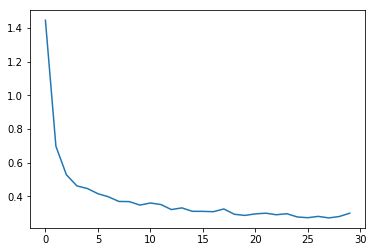

In [5]:
%%time
running_losses = list()
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, start=1): 
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)  # データを損失関数に突っ込む
        loss.backward()    # 誤差逆伝播(パラメータの変化の微分を計算)
        optimizer.step()   # 最適化手法をもとにパラメータ更新

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 100 mini-batches (1バッチは100枚 trainデータは60000枚あるので600までいく)
            running_loss_mean = running_loss / 100
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss_mean))
            running_losses.append(running_loss_mean)
            running_loss = 0.0


print('Finished Training')
f = plt.figure()
ax = f.add_subplot(111)
ax.plot(running_losses)
ax.add_title("損失関数の変化")
plt.show()